# 1. Imports and Loading the Network

The graph is loaded from the `sbb.edgelist`.
Make sure to create this edgelist through the `create_edgelist.py` script.

In [1]:
import pandas as pd
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
df = gpd.read_file('data/stations.geojson')
df['lon'] = df['geometry'].x
df['lat'] = df['geometry'].y
df['coords'] = [(lon, lat) for lon, lat in zip(df['geometry'].x, df['geometry'].y)]

In [3]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

for idx, row in df.iterrows():
    station_name = row['station_name']
    lon = row['lon']
    lat = row['lat']
    # Check if the station name exists in the graph
    if station_name in G.nodes:
        # Set latitude and longitude attributes
        G.nodes[station_name]['lon'] = lon
        G.nodes[station_name]['lat'] = lat
        G.nodes[station_name]['coords'] = (lon, lat)

print(G.nodes['Aadorf'])

{'lon': 8.90356210826161, 'lat': 47.4879328611259, 'coords': (8.90356210826161, 47.4879328611259)}


In [4]:
print(f"number of nodes: {len(G.nodes)}")
print(f"number of edges: {len(G.edges)}")

number of nodes: 3152
number of edges: 4678


# 2. Community Detection


In [5]:
import random

def community_stats(communities, algorithm_name):
    comms_len = [len(c) for c in communities]
    print(f"{algorithm_name}: number of communities: {len(communities)}")
    print(f"{algorithm_name}: size of each community: {comms_len}")


def plot_communities(G, communities, algorithm_name):
    getcolors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
    colors = getcolors(len(communities))

    plt.figure(figsize=(12, 9))    
    pos = nx.spring_layout(G, seed=42)     
    for i, c in enumerate(communities):   
        nx.draw_networkx_nodes(     
            G, pos=pos, nodelist=c, node_color=colors[i], node_size=10, alpha=0.75        
        )            

    nx.draw_networkx_edges(G, pos=pos, width=0.20, alpha=0.33)
    plt.title(f"{algorithm_name} Community Detection")
    plt.show()

## 2.1 Louvain

### 2.1.1 Louvain on the Entire Graph

In [6]:
louvain = nx.community.louvain_communities(G, seed=42, resolution=1)

community_stats(louvain, "Louvain")

Louvain: number of communities: 57
Louvain: size of each community: [98, 93, 131, 47, 25, 20, 26, 222, 15, 13, 117, 13, 30, 32, 12, 19, 137, 55, 83, 45, 18, 24, 99, 156, 51, 18, 20, 43, 12, 50, 3, 98, 27, 24, 74, 103, 38, 128, 20, 29, 17, 9, 202, 2, 212, 50, 50, 94, 20, 20, 79, 29, 64, 12, 7, 10, 7]


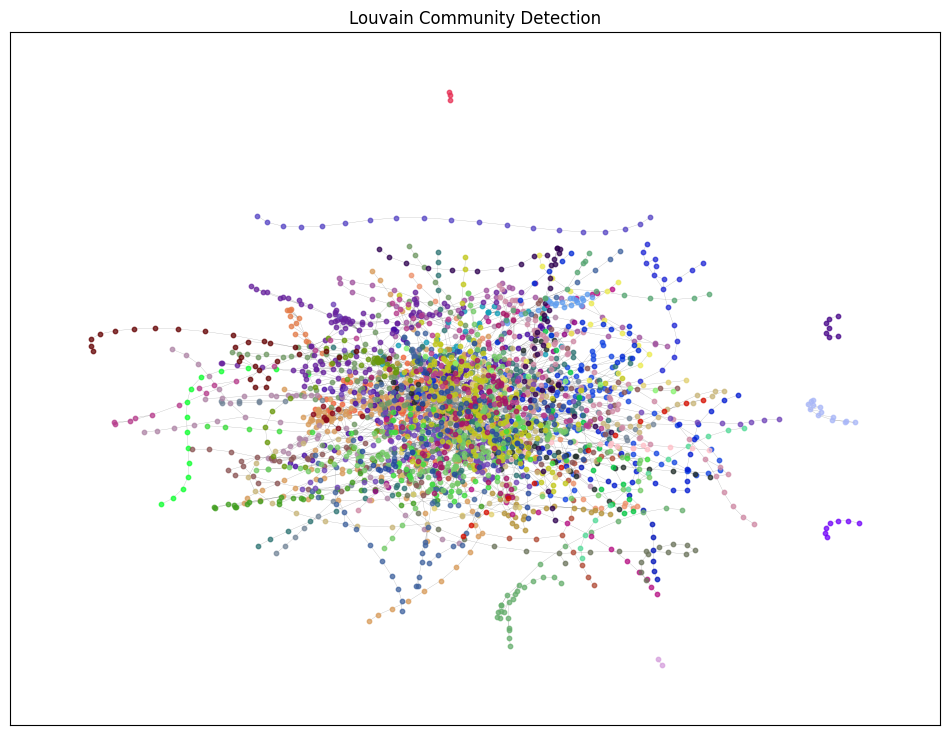

In [7]:
plot_communities(G, louvain, "Louvain")

### 2.1.2 Louvain with Largest Connected Components

In [8]:
connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
print("Number of nodes in largest connected component:", len(max_connected_comp))

sub_G = G.subgraph(max_connected_comp)
louvain = nx.community.louvain_communities(sub_G, seed=42, resolution=0.5)

community_stats(louvain, "Louvain LCC")       

Number of nodes in largest connected component: 3017
Louvain LCC: number of communities: 28
Louvain LCC: size of each community: [116, 34, 25, 186, 27, 233, 189, 142, 150, 167, 139, 207, 88, 51, 20, 268, 276, 104, 27, 24, 178, 17, 130, 50, 29, 20, 106, 14]


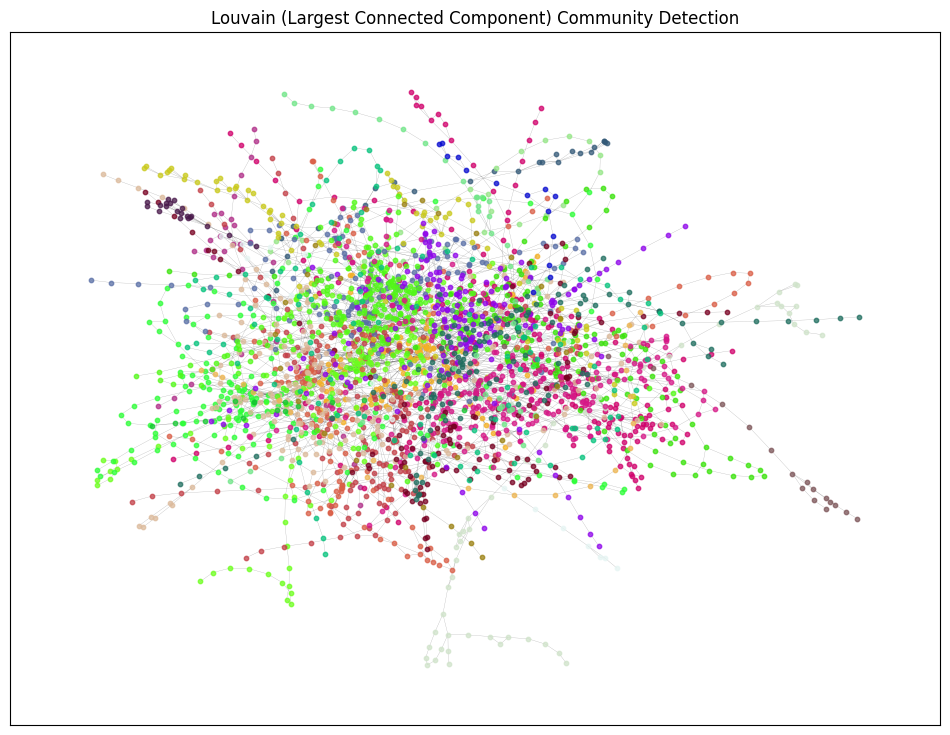

In [9]:
plot_communities(sub_G, louvain, "Louvain (Largest Connected Component)")

### 2.1.3 Louvain: Our Implementation

TODO: @Christian add our Louvain implementation

## 2.2 Girvan-Newman

In [10]:
import time

def girvan_newman(G, time_threshold=1):
    gn_communities = nx.community.girvan_newman(G)

    iter_count = 0
    coms = []

    # Apply Girvan-Newman iteratively for > time_threshold hour
    timeout = time.time() + 60 * time_threshold
    while True:
        if time.time() > timeout:
            break
        
        iter_count += 1
        coms = next(gn_communities, 'end')

    print(f'number of iterations: {iter_count}')
    return coms


gn = girvan_newman(G, time_threshold=3)

number of iterations: 1


In [11]:
community_stats(gn, "Girvan Newman")

Girvan Newman: number of communities: 13
Girvan Newman: size of each community: [1863, 1154, 20, 13, 30, 19, 12, 3, 2, 12, 7, 10, 7]


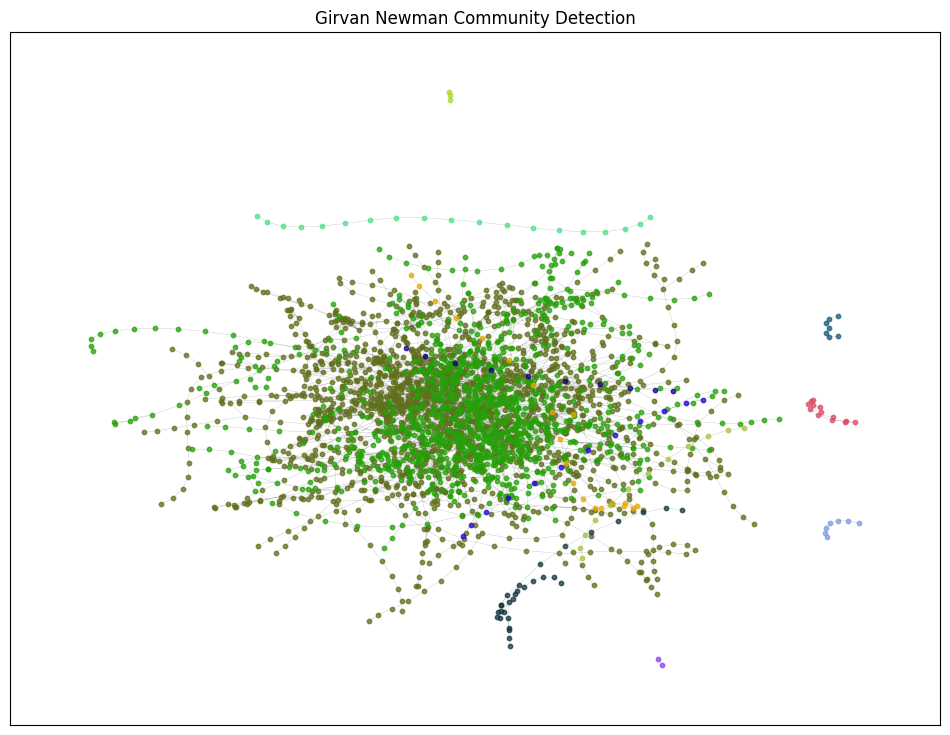

In [12]:
plot_communities(G, gn, "Girvan Newman")

## 2.3 Leiden

In [13]:
import leidenalg as la
import igraph as ig

def leiden_communities(graph):
    if isinstance(graph, nx.Graph):
        graph = ig.Graph.from_networkx(graph)

    partition = [set(comm) for comm in list(la.find_partition(graph, la.ModularityVertexPartition))]

    return partition

In [14]:
leiden = leiden_communities(G)

community_stats(leiden, "Leiden")

# TODO: plot leiden!
# leiden returns edge number, not name; we should fix this as well

Leiden: number of communities: 59
Leiden: size of each community: [218, 177, 142, 121, 114, 113, 113, 112, 104, 99, 96, 95, 95, 93, 90, 83, 80, 73, 67, 66, 60, 54, 53, 51, 50, 49, 49, 47, 44, 44, 35, 30, 29, 27, 25, 24, 24, 20, 20, 20, 20, 20, 19, 19, 18, 17, 15, 15, 15, 13, 13, 12, 12, 10, 9, 7, 7, 3, 2]


# 3. Benchmarks: Iteration Time

## Silhouette Score Function

In [ ]:
# TODO: do we still need this? 
from sklearn.metrics import silhouette_score

def silhouette_fn(G, found_communities, verbose=False):
    # make a dictionary with node as key and final community as value
    node_to_community = {node: comm_idx for comm_idx, community in enumerate(found_communities) for node in community}
    # list all final communities by indexing with keys
    comm_labels = [node_to_community[node] for node in G.nodes()]
    # # turn graph into numpy adjacency matrix
    matrix = nx.to_numpy_array(G)
    # calc silhouette score by inputting graph as an array and the communities as labels
    sil_score = silhouette_score(nx.to_numpy_array(G), comm_labels, metric='euclidean', random_state=42)
    if verbose:
        print("Silhouette Score:", s_score)
    return sil_score

## 3.1 Louvain

In [ ]:
import time

all_times = []
silhouette_scores = []
modularity_scores = []

for _ in range(10):
    louvain_partitions = nx.community.louvain_partitions(G)
    i_times = []
    i_silhouette = []
    i_modularity = []
    while True:
        start_time = time.time()
        communities = next(louvain_partitions, 'finished')
        stop_time = time.time()
        i_time = stop_time - start_time
        if communities == 'finished':
            break 
        i_times.append(i_time)
        s_score = silhouette_fn(G, communities)
        i_silhouette.append(s_score)
        m_score = nx.community.modularity(G, communities)
        i_modularity.append(m_score)
        final_communities = communities

    all_times.append(i_times)
    silhouette_scores.append(i_silhouette)
    modularity_scores.append(i_modularity)
    
    
print(f'iteration times: {all_times}')
print(f'silhouette scores per iteration: {silhouette_scores}')
print(f'modularity scores per iteration: {modularity_scores}')
print(f'final number of communities: {len(final_communities)}')

times_df = pd.DataFrame(all_times)
times_df.to_csv('data/nx_louvain_iteration_times.csv', index=False)
silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df.to_csv('data/nx_louvain_silhouette_scores_per_iteration.csv', index=False)
modularity_df = pd.DataFrame(modularity_scores)
modularity_df.to_csv('data/nx_louvain_modularity_scores_per_iteration.csv', index=False)

## 3.2 Girvan-Newman

In [ ]:
all_times = []
silhouette_scores = []
modularity_scores = []
timeout = time.time() + 60 * 60 # run for 20 hours

gn_partitions = nx.community.girvan_newman(G)
i_times = []
i_silhouette = []
i_modularity = []

while True:
    if time.time() > timeout:
        break
    start_time = time.time()
    communities = next(gn_partitions, 'finished')
    stop_time = time.time()
    i_time = stop_time - start_time
    if communities == 'finished':
        break 
    i_times.append(i_time)
    s_score = silhouette_fn(G, communities)
    i_silhouette.append(s_score)
    m_score = nx.community.modularity(G, communities)
    i_modularity.append(m_score)
    final_communities = communities
    

all_times.append(i_times)
silhouette_scores.append(i_silhouette)
modularity_scores.append(i_modularity)
    
print(f'iteration times: {all_times}')
print(f'silhouette scores per iteration: {silhouette_scores}')
print(f'modularity scores per iteration: {modularity_scores}')
print(f'final number of communities: {len(final_communities)}')

times_df = pd.DataFrame(all_times)
times_df.to_csv('data/nx_gn_iteration_times.csv', index=False)
silhouette_df = pd.DataFrame(silhouette_scores)
silhouette_df.to_csv('data/nx_gn_silhouette_scores_per_iteration.csv', index=False)
modularity_df = pd.DataFrame(modularity_scores)
modularity_df.to_csv('data/nx_gn_modularity_scores_per_iteration.csv', index=False)

## 3.3 Leiden

In [ ]:
# TODO: Benchmark Leiden